# Imports

In [1]:
import dictdiffer
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pathlib
import pprint
import seaborn as sns
import scipy.special as sp
import sys

from typing import *
from google.protobuf.json_format import MessageToDict

# (disable?) label latex support for matplotlib
plt.rcParams['text.usetex'] = False

# import protobuf module.
a_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'python_generated'))
sys.path.insert(0, a_path)
import message_pb2 as pb

/opt/homebrew/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.3 is exactly one major version older than the runtime version 6.31.0 at message.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


# Load data

In [2]:
RESULTS_DIRECTORY = pathlib.Path('../../data/no-drug-power-law-phase-transition/')
experiments: List[pb.Experiment] = []
# Read the existing address book.
for protobuf_file in RESULTS_DIRECTORY.glob('*.pb'):
  with protobuf_file.open('rb') as f:
    experiment = pb.Experiment()
    experiment.ParseFromString(f.read())
    experiments.append(experiment)

# Data check

In [3]:
control_experiment = experiments[0]
# Note that homogeneously distributed networks have type 0.
assert control_experiment.experiment_config.network_config.out_degree_distribution_type == 1, "network should be power law"
assert all(
  experiment.experiment_config.dynamics_config == control_experiment.experiment_config.dynamics_config
  for experiment in experiments
), "dynamics config differs"
assert all(
  experiment.experiment_config.drug_config == control_experiment.experiment_config.drug_config
  for experiment in experiments
), "drug config differs"
assert all(
  experiment.experiment_config.network_config.network_size == control_experiment.experiment_config.network_config.network_size
  for experiment in experiments
), "network size differs"
assert all(
  experiment.experiment_config.network_config.out_degree_distribution_type == control_experiment.experiment_config.network_config.out_degree_distribution_type
  for experiment in experiments
), "not all networks are power law distributed"
control_experiment.experiment_config

num_networks: 100
dynamics_config {
  num_steps: 30
  num_initial_conditions: 20
}
network_config {
  network_size: 500
  expected_connectivity: 11.499999999999996
  out_degree_distribution_type: OUT_DEGREE_DISTRIBUTION_TYPE_POWER_LAW
  power_law_out_degree_distribution {
    gamma: 1.6269580220678381
  }
}
drug_config {
}

# Format data

In [4]:
# (experiment, network, initial_condition, time/step, node_idx)
A = (
  np.array([
    np.array([
      np.array([
        np.array([
          np.array(state.state)
          for state in trajectory.states
        ])
        for trajectory in result.perturbations[0].trajectories
      ])
      for result in experiment.results
    ])
    for experiment in experiments
  ])
)

assert A.shape == (
  len(experiments),
  control_experiment.experiment_config.num_networks,
  control_experiment.experiment_config.dynamics_config.num_initial_conditions,
  control_experiment.experiment_config.dynamics_config.num_steps+1,
  control_experiment.experiment_config.network_config.network_size,
), A.shape

# Compute hamming distances

In [5]:
hamming_distance_data = []

for experiment_idx, experiment in enumerate(experiments):
  for network_idx in range(experiment.experiment_config.num_networks):
    for initial_condition_idx_1 in range(experiment.experiment_config.dynamics_config.num_initial_conditions):
      for initial_condition_idx_2 in range(initial_condition_idx_1 + 1, experiment.experiment_config.dynamics_config.num_initial_conditions):
        hs = (A[experiment_idx,network_idx,initial_condition_idx_1] ^ A[experiment_idx, network_idx,initial_condition_idx_2]).mean(axis=1)
        for step_num, h in enumerate(hs):
          hamming_distance_data.append({
            'K': experiment.experiment_config.network_config.expected_connectivity,
            'gamma': experiment.experiment_config.network_config.power_law_out_degree_distribution.gamma,
            'experiment_idx': experiment_idx,
            'network_idx': network_idx,
            'trial_idx': initial_condition_idx_2 * experiment.experiment_config.dynamics_config.num_initial_conditions + initial_condition_idx_1,
            'step_num': step_num,
            'hamming_distance': h,
          })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

# Plot hamming distance vs time for various K

In [ ]:
figure = plt.figure(figsize=(20, 10))
palette = sns.color_palette("dark:salmon_r", as_cmap=True)
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.lineplot(
    data=hamming_distance_df,
    x='step_num',
    y='hamming_distance',
    hue='K',
    palette=palette,
    legend=False,
  )
  g.set(xlabel='Time', ylabel='Hamming distance')
  Ks = sorted(hamming_distance_df['K'].unique())
  norm = plt.Normalize(vmin=Ks[0], vmax=Ks[-1])
  sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
  cb = g.figure.colorbar(sm, ax=g)
  cb.set_ticks(Ks)
  cb.ax.set_ylabel('$\\langle K \\rangle$')

# Plot steady state hamming distance vs K

In [6]:
steady_state_hamming_distance_df = hamming_distance_df[
  hamming_distance_df['step_num'] == control_experiment.experiment_config.dynamics_config.num_steps
].drop(columns=['step_num'])

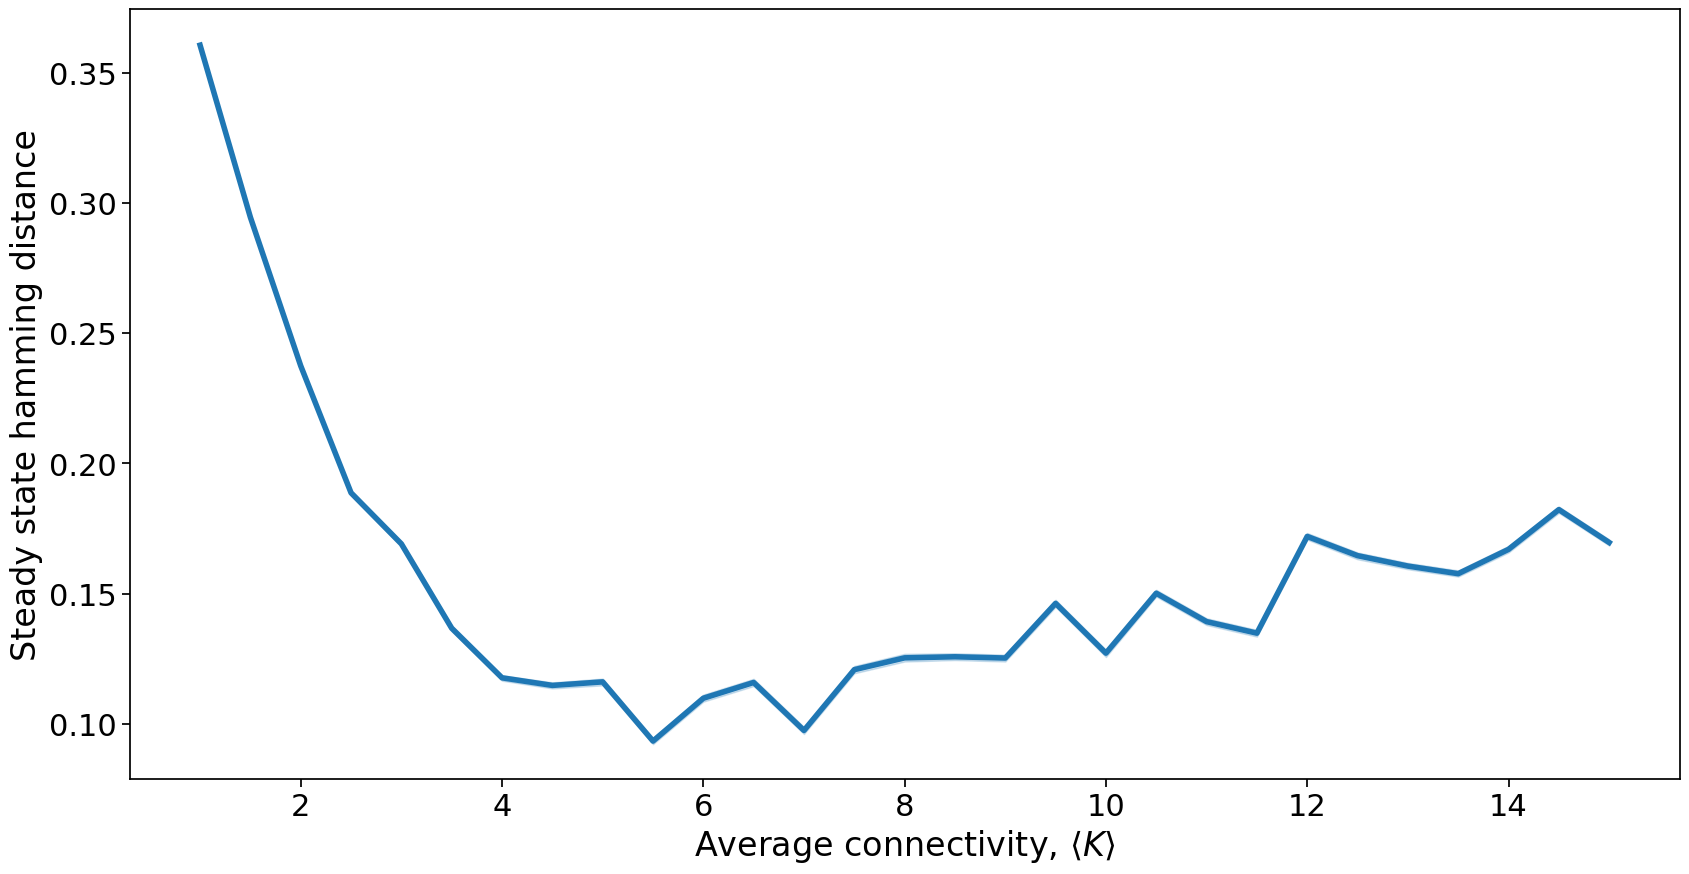

In [ ]:
plt.figure(figsize=(20, 10))
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.lineplot(
    data=steady_state_hamming_distance_df,
    x='K',
    y='hamming_distance',
    lw=4,
    legend=False,
  )
  g.set(xlabel='Average connectivity, $\\langle K \\rangle$', ylabel='Steady state hamming distance')

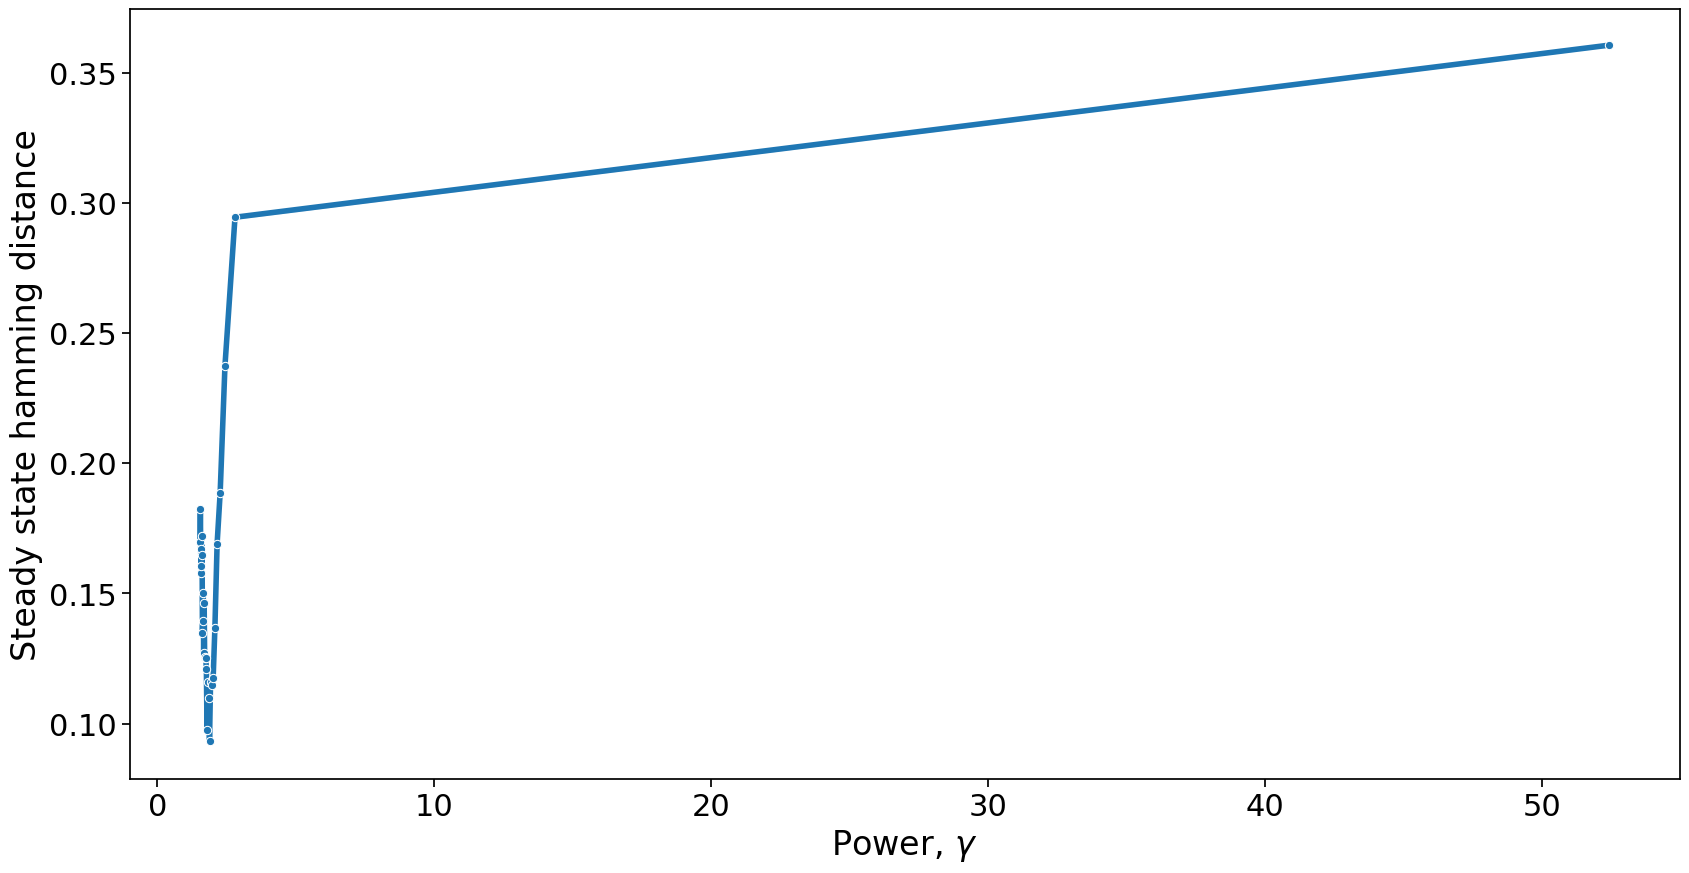

In [9]:
plt.figure(figsize=(20, 10))
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.lineplot(
    data=steady_state_hamming_distance_df,
    x='gamma',
    y='hamming_distance',
    lw=4,
    marker='o',
    legend=False,
  )
  g.set(xlabel='Power, $\\gamma$', ylabel='Steady state hamming distance')